In [ ]:
import pandas
import numpy
import sklearn
import matplotlib
import mediapipe 
import cv2 

# Random Forest Classifer

In [2]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

is_mac = True 

path = 'C:\\Users\\moham\\Desktop\\Third Year Project\\Dataset\\' if not is_mac else '/Users/mohamed/ZenAI-3YP/Dataset/'

columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']

y82_test = pd.read_csv(path+'y82_testing.csv', header=None)
y82_train = pd.read_csv(path+'y82_training.csv', header=None)
L_test = pd.read_csv(path+'L_testing.csv', header=None)
L_train = pd.read_csv(path+'y82_training.csv', header=None)

df = pd.concat([y82_train, y82_test, L_test, L_train])

df.columns = columns

df['class'], classes = pd.factorize(df['class'])
classes = list(classes)

X = df.drop('class', axis=1)
y = df['class']

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

max_estimators = 100
max_depth = 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest_classifier = RandomForestClassifier()
param_grid = {'n_estimators' : np.arange(1, max_estimators + 1),
              'max_depth' : np.arange(1, max_depth + 1),
            }

forest_classifier_gscv = GridSearchCV(forest_classifier, param_grid, cv=5, verbose=True)

#fit model to data
forest_classifier_gscv.fit(X_train, y_train)

forest_classifier_gscv.best_params_
forest_classifier_gscv.best_score_

Fitting 5 folds for each of 700 candidates, totalling 3500 fits


0.9421896255988644

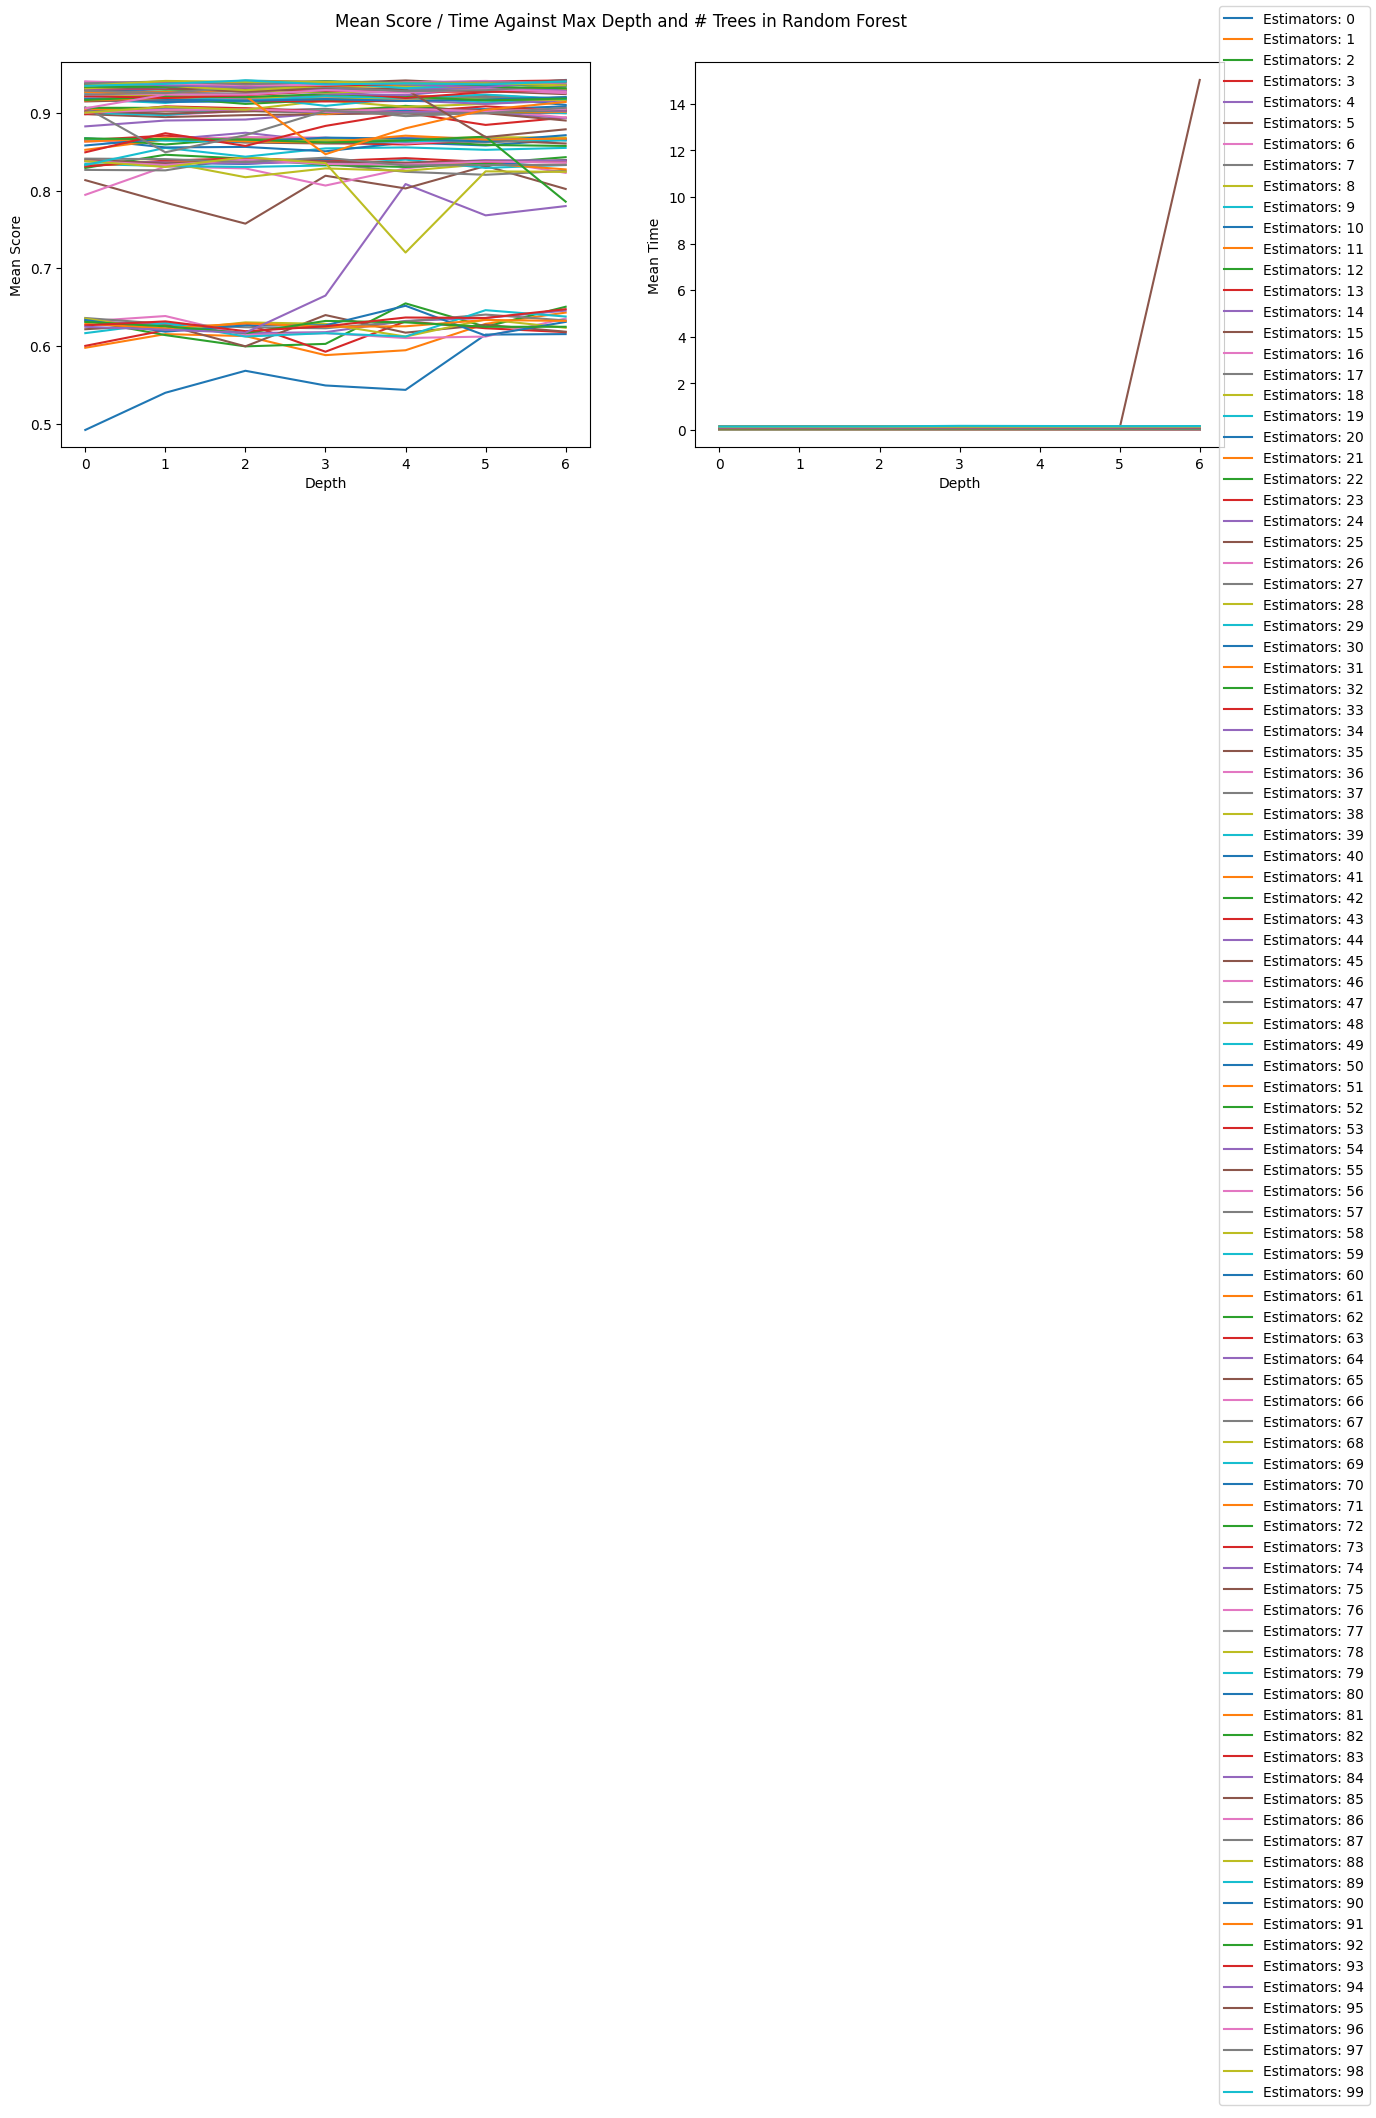

In [11]:
def plot_hyperparams():
    att = [x for x in forest_classifier_gscv.cv_results_]

    scores = [x for x in forest_classifier_gscv.cv_results_['mean_test_score']]
    times = [x for x in forest_classifier_gscv.cv_results_['mean_fit_time']]

    scores = np.array(scores).reshape(max_estimators, max_depth)
    times = np.array(times).reshape(max_estimators, max_depth)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Mean Score / Time Against Max Depth and # Trees in Random Forest ')

    for idx in range(max_estimators):
        ax1.plot(range(max_depth), scores[idx], label='Estimators: ' + str(idx))
        ax2.plot(range(max_depth), times[idx], label='Estimators: ' + str(idx))
        
    ax1.set(xlabel='Depth', ylabel='Mean Score') 
    ax2.set(xlabel='Depth', ylabel='Mean Time') 
        
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()
plot_hyperparams()

# Plotting Testing / Training Error on Max Depth and # Estimators

In [4]:
max_depth = forest_classifier_gscv.best_params_['max_depth']
n_estimators = forest_classifier_gscv.best_params_['n_estimators']

best_forest = RandomForestClassifier(max_depth = max_depth, n_estimators=n_estimators)
best_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=14)

# Video & Classifer Integration

In [5]:
import cv2
import mediapipe as mp
import numpy as np
import time 

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5

# All landmark except for hand and face specific
RelevantLandmarks = list(mp_pose.PoseLandmark)[11:17] + list(mp_pose.PoseLandmark)[23:29]

l_hip_landmark_angle_idx = (11,23,25)
r_hip_landmark_angle_idx = (12,24,26)

l_shoulder_landmark_angle_idx = (13,11,23)
r_shoulder_landmark_angle_idx = (14,12,24)

l_arm_landmark_angle_idx = (15,13,11)
r_arm_landmark_angle_idx = (16,14,12)

l_knee_landmark_angle_idx = (23,25,27)
r_knee_landmark_angle_idx = (24,26,28)

#Match idx of RelevantLandmarks 
angle_idxs_required = [
    l_shoulder_landmark_angle_idx,
    r_shoulder_landmark_angle_idx,
    
    l_arm_landmark_angle_idx,
    r_arm_landmark_angle_idx,
    
    l_hip_landmark_angle_idx,
    r_hip_landmark_angle_idx,
    
    l_knee_landmark_angle_idx,
    r_knee_landmark_angle_idx
]
skip_landmark = {
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_WRIST,
    mp_pose.PoseLandmark.LEFT_WRIST
}

In [6]:
landmarkStr = {
    mp_pose.PoseLandmark.NOSE : "NOSE",
    mp_pose.PoseLandmark.LEFT_EYE_INNER : "LEFT_EYE_INNER",
    mp_pose.PoseLandmark.LEFT_EYE : "LEFT_EYE",
    mp_pose.PoseLandmark.LEFT_EYE_OUTER : "LEFT_EYE_OUTER",
    mp_pose.PoseLandmark.RIGHT_EYE_INNER : "RIGHT_EYE_INNER",
    mp_pose.PoseLandmark.RIGHT_EYE : "RIGHT_EYE",
    mp_pose.PoseLandmark.RIGHT_EYE_OUTER : "RIGHT_EYE_OUTER",
    mp_pose.PoseLandmark.LEFT_EAR : "LEFT_EAR",
    mp_pose.PoseLandmark.RIGHT_EAR : "RIGHT_EAR",
    mp_pose.PoseLandmark.MOUTH_LEFT : "MOUTH_LEFT",
    mp_pose.PoseLandmark.MOUTH_RIGHT : "MOUTH_RIGHT",
    mp_pose.PoseLandmark.LEFT_SHOULDER : "LEFT_SHOULDER",
    mp_pose.PoseLandmark.RIGHT_SHOULDER : "RIGHT_SHOULDER",
    mp_pose.PoseLandmark.LEFT_ELBOW : "LEFT_ELBOW",
    mp_pose.PoseLandmark.RIGHT_ELBOW : "RIGHT_ELBOW",
    mp_pose.PoseLandmark.LEFT_WRIST : "LEFT_WRIST",
    mp_pose.PoseLandmark.RIGHT_WRIST : "RIGHT_WRIST",
    mp_pose.PoseLandmark.LEFT_PINKY : "LEFT_PINKY",
    mp_pose.PoseLandmark.RIGHT_PINKY : "RIGHT_PINKY",
    mp_pose.PoseLandmark.LEFT_INDEX : "LEFT_INDEX",
    mp_pose.PoseLandmark.RIGHT_INDEX : "RIGHT_INDEX",
    mp_pose.PoseLandmark.LEFT_THUMB : "LEFT_THUMB",
    mp_pose.PoseLandmark.RIGHT_THUMB : "RIGHT_THUMB",
    mp_pose.PoseLandmark.LEFT_HIP : "LEFT_HIP",
    mp_pose.PoseLandmark.RIGHT_HIP : "RIGHT_HIP",
    mp_pose.PoseLandmark.LEFT_KNEE : "LEFT_KNEE",
    mp_pose.PoseLandmark.RIGHT_KNEE : "RIGHT_KNEE",
    mp_pose.PoseLandmark.LEFT_ANKLE : "LEFT_ANKLE",
    mp_pose.PoseLandmark.RIGHT_ANKLE : "RIGHT_ANKLE",
    mp_pose.PoseLandmark.LEFT_HEEL : "LEFT_HEEL",
    mp_pose.PoseLandmark.RIGHT_HEEL : "RIGHT_HEEL",
    mp_pose.PoseLandmark.LEFT_FOOT_INDEX : "LEFT_FOOT_INDEX",
    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX : "RIGHT_FOOT_INDEX"
}

def calc_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)    
    c = np.array(c)   
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 380-angle 
    
    return angle 

AttributeError: 'RandomForestClassifier' object has no attribute 'feature_names_'

In [12]:
def classify_pose(example):
    example = pd.DataFrame(np.array(example).reshape(1, -1), columns=columns[1:])
    
    probabilty_classes = best_forest.predict_proba(example)
    
    prob_predicted_classes = [] 
    for class_idx, prob in enumerate(probabilty_classes[0]):
        prob_predicted_classes.append((classes[class_idx], prob))
        
    prob_predicted_classes.sort(key = lambda x: x[1], reverse=True)
    
    # Get the highest predicted class 
    predicted_class = prob_predicted_classes[0]
    
    return (predicted_class, sorted(prob_predicted_classes, key = lambda x: x[1], reverse=True))

classify_pose([8.390697637127042, 13.364568331384618, 16.49759248897499, 153.50000646379374, 173.20291493738577, 199.52935190007366, 179.00845878279233, 198.25172013734928])

(('Cobra', 0.4250888430454994),
 [('Cobra', 0.4250888430454994),
  ('WarriorIII', 0.23203473513071038),
  ('Tree', 0.14897821476768844),
  ('Chair', 0.10535955272797379),
  ('DownDog', 0.08853865432812802)])

In [14]:

''' Using the media pose model'''
with mp_pose.Pose(min_detection_confidence=MIN_DETECTION_CONFIDENCE, min_tracking_confidence=MIN_TRACKING_CONFIDENCE) as pose:
    '''
        Capturing webcam footage 
    '''
    cap = cv2.VideoCapture(0) # this is the magic!

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    while cap.isOpened():
        suc, frame = cap.read() 
        if not suc:
            print("Frame empty..")
            continue 
        
        #Recolor image 
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detections 
        results = pose.process(image=image)
        pose_landmarks = results.pose_landmarks
        try: 
            pose_relevant_landmark_angles = []
            # Going through all relevant landmarks, extracting their key angles
            # Calculating the angle then adding to array 
            for i1, i2, i3 in angle_idxs_required:
                
                fst = (pose_landmarks.landmark[i1].x, pose_landmarks.landmark[i1].y)
                snd = (pose_landmarks.landmark[i2].x, pose_landmarks.landmark[i2].y)
                thrd = (pose_landmarks.landmark[i3].x, pose_landmarks.landmark[i3].y)
                
                
                pose_relevant_landmark_angles.append(calc_angle(fst, snd, thrd))
            #Getting cords of the landmarks FOR ANGLES WE CALC'D CORDS FOR
            pose_relevant_landmark_cords = [[pose_landmarks.landmark[idx].x, pose_landmarks.landmark[idx].y]
                                            for _, idx, _ in angle_idxs_required if idx not in skip_landmark]
            
            pose_relevant_landmark_angles_visual = np.around(pose_relevant_landmark_angles, 2).astype(str).tolist()
            
            ''' CLASSIFICATION OF POSE''' 
            predicted_pose, prob_predictions = classify_pose(pose_relevant_landmark_angles)
            
            
            if (predicted_pose[1] >= 0.55):
                print(predicted_pose)
            else:
                print("No Pose Detected")
            #Revert image color 
            image.flags.writeable = True 
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            #Render detections 
            mp_drawing.draw_landmarks(
                image, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(50, 145, 168), circle_radius=2, thickness=2),
                mp_drawing.DrawingSpec(color=(209, 192, 42), circle_radius=2, thickness=2)
            )
            
            cv2.putText(image, 
                            predicted_pose[0],
                            tuple(np.multiply([640//2,480//2], [640, 480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA 
                        ) 
        
        except Exception as e:
        
            print(e)
            
        # Displaying the frame 
        cv2.imshow("Video", image)
        
        # Closing the video capture  
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
cap.release() 
cv2.destroyAllWindows()

No Pose Detected
No Pose Detected
No Pose Detected
('WarriorIII', 0.5509153790715992)
('WarriorIII', 0.5739654996826953)
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Detected
No Pose Dete